<a href="https://colab.research.google.com/github/amuradbegovic/rang-lista-svjetskih-univerziteta-vis/blob/main/VIS25-Z2-TIM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zadaća 2 - Statistička analiza svjetskih univerziteta

Tim 1: **Adnan Muradbegović, Aid Mustafić, Tarik Redžić, Zlatan Ljutika**

---

Teško je pronaći opću mjeru kvalitete za visokoobrazovne institucije, s tim da se većina univerziteta širom svijeta bavi mnogim različitim oblastima, kao što su nastava, istraživanje i razmjena znanja. 
Ipak, odlučiti se za način predviđanja ukupne kvalitete institucije bilo bi poželjno za one koji žele donijeti informisanu odluku o tome da li da se angažuju s određenim univerzitetom, bilo kao student, istraživač ili partner iz industrije.

U ovom projektu, izvršavamo statističku analizu _[Times Higher Education](https://www.timeshighereducation.com)_ rang liste svjetskih univerziteta za 2024. godinu.

Izvor podataka: <br>
**[Dosad, D. (2024), Times World University Rankings 2024](https://www.kaggle.com/datasets/ddosad/timesworlduniversityrankings2024)**



In [2]:
# Učitavanje nužnih biblioteka i inicijalizacija seta podataka za rad
# !curl -LJO https://raw.githubusercontent.com/amuradbegovic/rang-lista-svjetskih-univerziteta-vis/main/TIMES_WorldUniversityRankings_2024.csv
# Ne do vam Bog ovo uncomment-irat i runat dok nismo završili. (Privatni je repo pa samo OBRIŠE ČITAV CSV I STAVI "404 NOT FOUND")

import pandas as pd                   ## Za manipulisanje golih podataka, (CSV, DataFrame,...)
import matplotlib.pyplot as plt       ## Za vizualizaciju podataka
import seaborn as sns                 ## Za vizualizaciju podat
import numpy as np                    ## Za izvršavanje matematičkih operacija nad podacima
from numpy import cov
from IPython.display import HTML    ## Za kreiranje tabela i HTML manipulaciju
from IPython.display import Markdown
import statistics

df = pd.read_csv("TIMES_WorldUniversityRankings_2024.csv")

# Nužni koraci, postoje greške u notaciji polja i tipovima podataka u datasetu.
# Procent intl. studenta je sada 0.X, umjesto X%
# Proporcija ženskih-muških studenata je sada 0.X, umjesto 'X : Y'
# N/A podaci su zapisani kao proracunati mean
df['stats_number_students'] = df['stats_number_students'].str.replace(',', '').astype(float) 

mask = df['stats_pc_intl_students'].str.match(r'^\d+(\.\d+)?%$')
df.loc[~mask, 'stats_pc_intl_students'] = '0%'
df['stats_pc_intl_students'] = df['stats_pc_intl_students'].str.rstrip('%')
df['stats_pc_intl_students'] = (df['stats_pc_intl_students'].astype(float) / 100)

df['stats_female_male_ratio'] = df['stats_female_male_ratio'].astype(str).str.replace(' ','',regex=False)
mask = df['stats_female_male_ratio'].str.match(r'^\d+\s*:\s*\d+$')
female_ratio = df.loc[mask, 'stats_female_male_ratio'].str.replace(' ', '', regex=False).str.split(':')
female_ratio = female_ratio.apply(lambda x: int(x[0]) / (int(x[0]) + int(x[1])))
mean_f_ratio = female_ratio.mean()

df['stats_female_male_ratio'] = None
df.loc[mask, 'stats_female_male_ratio'] = female_ratio
df['stats_female_male_ratio'] = df['stats_female_male_ratio'].astype(float).fillna(mean_f_ratio)
df['female_ratio_imputed'] = ~mask # Ubačen flag da li je ubačena vrijednost ili ne. (Bool: da li je ubačena?)

### 1. Deskriptivna statistika i vizualizacija distribucija podataka

Član tima: **Tarik Redžić**

---

 _THE (Times Higher Education) rang lista svjetskih univerziteta 2024. godine_ rangira ukupno **1904 univerziteta** iz 108 zemalja i regija.  
 U ovom poglavlju nastojimo prvenstveno opisati i upoznati se sa metodologijom rangiranja, načinom obrade podataka u ovom setu te korištenim parametrima.
 _U nastavku, važna je napomena da opis seta podataka i rang liste analogno važe jedno za drugo._

_Jedna zanimljivost, koju ćemo posebno razmatrati, je da je ovo **prvi put da se Univerzitet u Sarajevu ili uopšte jedna visokoobrazovna institucija iz Bosne i Hercegovine pojavi na ovoj rang listi**, što je čak istaknuto na službenoj web-stranici rang liste:_ 
> ,,Four countries enter the ranking for the first time – all of them in Europe. The addition of Kosovo, Bosnia and Herzegovina, North Macedonia and Armenia..."



##### **Metodologija i parametri**  
> ,,The table is based on our new WUR 3.0 methodology, which includes 18 carefully calibrated performance indicators that measure an institution’s performance across five areas: teaching, research environment, research quality, industry, and international outlook."  
  \- Times Higher Education
  


  _Set podataka se sastoji od:_  
* **Broj redova (univerziteta): _2673_**
    
    Pored 1904 rangiranih univerziteta, ***postoje 769 sa 'Reporter' statusom,*** tj. univerziteti koji su proslijedili podatke ali nisu zadovoljavali kriterij za rank, ali su prihvatili da budu prikazani kao "reporteri" u konačnoj tabeli.  
    *(Primjer, na jednoj rang listi, sa Reporter statusom se nalazi "University of Mostar", da li to bio UNMO/Džemal Bijedić ili SUM/Sveučilište u Mostaru, nije poznato, te se ne broji kao visokoobrazovna ustanova uvrštena u ovu rang listu)*

* **Broj kolona: _29, od kojih je 17 parametara pokazatelja učinka iz metodologije._**

   ***Parametri su grupisani na sljedeći način:***  
     * Teaching _(bos. **'Nastava'**, u datasetu: **'scores_teaching'**)_
        * Teaching Reputation _(bos. **'Reputacija nastave'**)_
        * Student Staff Ratio _(bos. **Proporcija Student-Osoblje,** u datasetu: **'stats_student_staff_ratio'**)_
        * Doctorate Bachelor Ratio _(bos. **Proporcija Doktorat-Bakalaureat,**)_
        * Doctorate Staff Ratio _(bos. **Proporcija Doktorat-Osoblje,**)_
        * Institutional Income _(bos. **Prihod institucije,**)_
        * Research Environment _(bos. **Istraživačko okruženje**)_
        * Research Reputation _(bos. '**Istraživačka reputacija**)_
        * Research Income _(bos. **Prihodi od istraživanja,**)_
        * Research Productivity _(bos. **Produktivnost u istraživanju,**)_
        * Research Quality _(bos. **Kvaliteta istraživanja,**)_
        * Citation Impact _(bos. **Uticaj pri citiranju,** u datasetu: **'scores_citation'**)_
        * Research Strength _(bos. **Istraživačka snaga,**)_
        * Research Excellence _(bos. **Kvaliteta istraživanja,**)_
        * Research Influence _(bos. **Istraživački uticaj,**)_
    * International outlook _(bos. **'Međunarodni povezanost'**, u datasetu: **'scores_international_outlook'**)_
        * International Students _(bos. **Međunarodni studenti,** u datasetu: **'stats_pc_intl_students'**)_
        * International Staff _(bos. **Međunarodno osoblje**)_
        * International Co-authorship _(bos. **Međunarodno koautorstvo**)_
    * Industry
        * Industry Income _(bos. **Prihodi od industrije,** u datasetu: **'scores_industry_income'**)_
        * Patents _(bos. **Patenti**)_


_**Napomena:** Radi statističke analize, ovo nije potpuni spisak parametara, već onih obrađenih i prevedenih u ovaj set podataka kao parametri. Više informacija o WUR metodologiji možete pronaći [ovdje.](https://www.timeshighereducation.com/sites/default/files/the_2024_world_university_rankings_methodology.pdf)_


In [83]:
# TODO: @TarikRedzic, fino ispuni ovo gore. Ostavio sam ti template. Što nema u datasetu, obriši, zato ti je ova posljednja rečenica.

In [84]:
###@title **Tabela 1: Primjer zapisa u setu podataka"** { display-mode: "form" }
display(df[df['scores_overall_rank'] == 18290])
display(Markdown('Tabela 1: Primjer zapisa u setu podataka'))

,rank,name,scores_overall,scores_overall_rank,scores_teaching,scores_teaching_rank,scores_research,scores_research_rank,scores_citations,scores_citations_rank,...,stats_student_staff_ratio,stats_pc_intl_students,stats_female_male_ratio,aliases,subjects_offered,closed,unaccredited,disabled,website_url,female_ratio_imputed
1828,1501+,University of Sarajevo,9.7–22.7,18290,16.40,1673,10.80,1552,18.60,1707,...,15.60,0.00,0.64,University of Sarajevo,"Languages, Literature & Linguistics,Agricultur...",False,False,False,NaN,False


Tabela 1: Primjer zapisa u setu podataka

In [85]:
df_display = df[['scores_overall_rank','scores_teaching','scores_research','scores_citations','scores_international_outlook','stats_number_students','scores_industry_income','stats_pc_intl_students','stats_female_male_ratio']]
pd.set_option('display.float_format', '{:.2f}'.format)
print("Tabela 2: Osnovne mjere varijacije i centralne težnje za odabrane numeričke parametre") # TODO: @TarikRedzic, ovo ljepše ispiši
df_display.describe()


Tabela 2: Osnovne mjere varijacije i centralne težnje za odabrane numeričke parametre


,scores_overall_rank,scores_teaching,scores_research,scores_citations,scores_international_outlook,stats_number_students,scores_industry_income,stats_pc_intl_students,stats_female_male_ratio
count,2673.00,1904.00,1904.00,1904.00,1904.00,2673.00,1904.00,2673.00,2673.00
mean,294587.23,29.06,23.42,52.19,49.91,18357.77,47.06,0.10,0.51
std,448657.02,13.97,16.70,25.07,21.83,23325.31,26.15,0.13,0.14
min,10.00,9.40,4.60,3.40,16.10,25.00,15.60,0.00,0.00
25%,6690.00,19.40,11.80,30.40,31.98,6175.00,22.27,0.01,0.44
50%,13370.00,25.80,17.25,52.40,45.30,12771.00,41.05,0.05,0.53
75%,1000101.00,34.50,29.90,73.22,65.40,23951.00,68.20,0.13,0.59
max,1000769.00,99.00,100.00,99.70,98.80,482541.00,100.00,1.00,1.00


In [86]:
# TODO: @TarikRedzic, izvuci neki zakljucak ako ima ili navedi koje sam promjene uradio na vrhu notebook-a (tipa ono sa meanom)

Prolaskom kroz bazu podataka vidljivo je da mnogi univerziteti ili nemaju nikakvog uspjeha u pogledu prethodno navedenih kriterija ili o njima jednostavno nisu dostupni dovoljno precizni podaci, pa je odluka bila na ta prazna mjesta staviti vrijednost 0, tako da ćemo sada vizualizirati stanje bez takvih univerziteta.

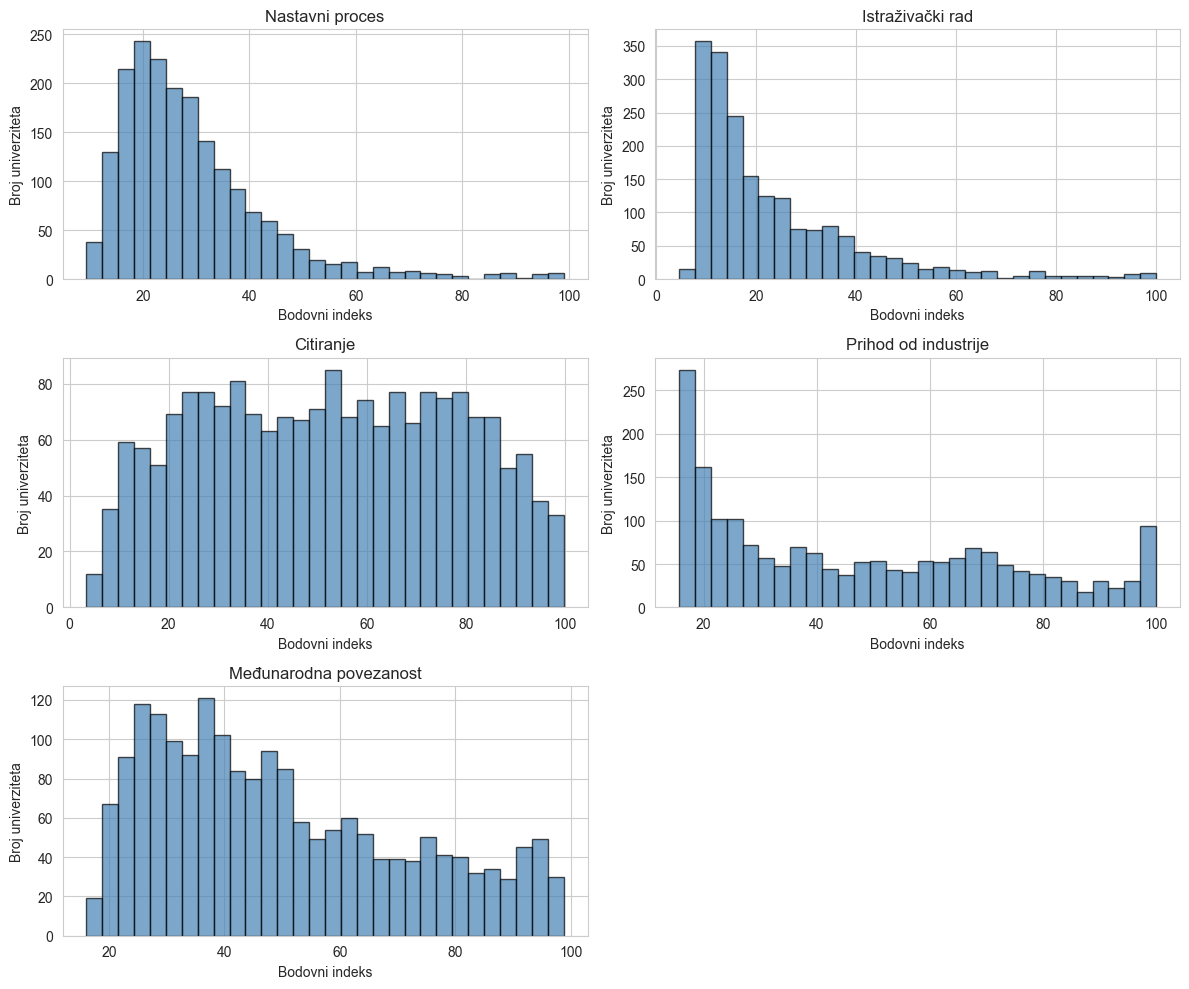

In [87]:
major_scores = [
    'scores_teaching',
    'scores_research',
    'scores_citations',
    'scores_industry_income',
    'scores_international_outlook'
]

for col in major_scores:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False).str.strip()
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[f'{col}_imputed'] = df[col].isna()
    df[col] = df[col].fillna(0)

filtered_data = {}
for col in major_scores:
    filtered_data[col] = df[df[col] > 0][col]

imputed_counts = {}
actual_counts = {}
valid_counts = {}  

for col in major_scores:
    imputed_col = f'{col}_imputed'
    imputed_counts[col] = df[imputed_col].sum()
    actual_counts[col] = len(df) - df[imputed_col].sum()
    valid_counts[col] = len(filtered_data[col])  


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(major_scores):
    axes[i].hist(filtered_data[col], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    
    #title = f"{col.replace('scores_', '').replace('_', ' ').title()}\n"
    #title += f"(Valid: {valid_counts[col]}, Zeros: {actual_counts[col] - valid_counts[col]}, Missing: {imputed_counts[col]})"
    
    match i:
        case 0:
            title = f"Nastavni proces"
        case 1:
            title = f"Istraživački rad"
        case 2:
            title = f"Citiranje"
        case 3:
            title = f"Prihod od industrije"
        case 4:
            title = f"Međunarodna povezanost"


    axes[i].set_title(title)
    axes[i].set_xlabel('Bodovni indeks')
    axes[i].set_ylabel('Broj univerziteta')

if len(major_scores) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

Sada imamo puno bolji uvid u realno stanje te možemo vidjeti distribucije koje jako podsjećaju na neke poznate oblike. Recimo distribucija za istraživački rad jako podsjeća na gamma distribuciju, dok nastavni proces i u neku ruku i međunarodna povezanost podsjećaju na lognormalnu distribuciju. Dotaknuti ćemo se dodatne analize nešto kasnije.

Pogledajmo kakvo je stanje po kontinentima.

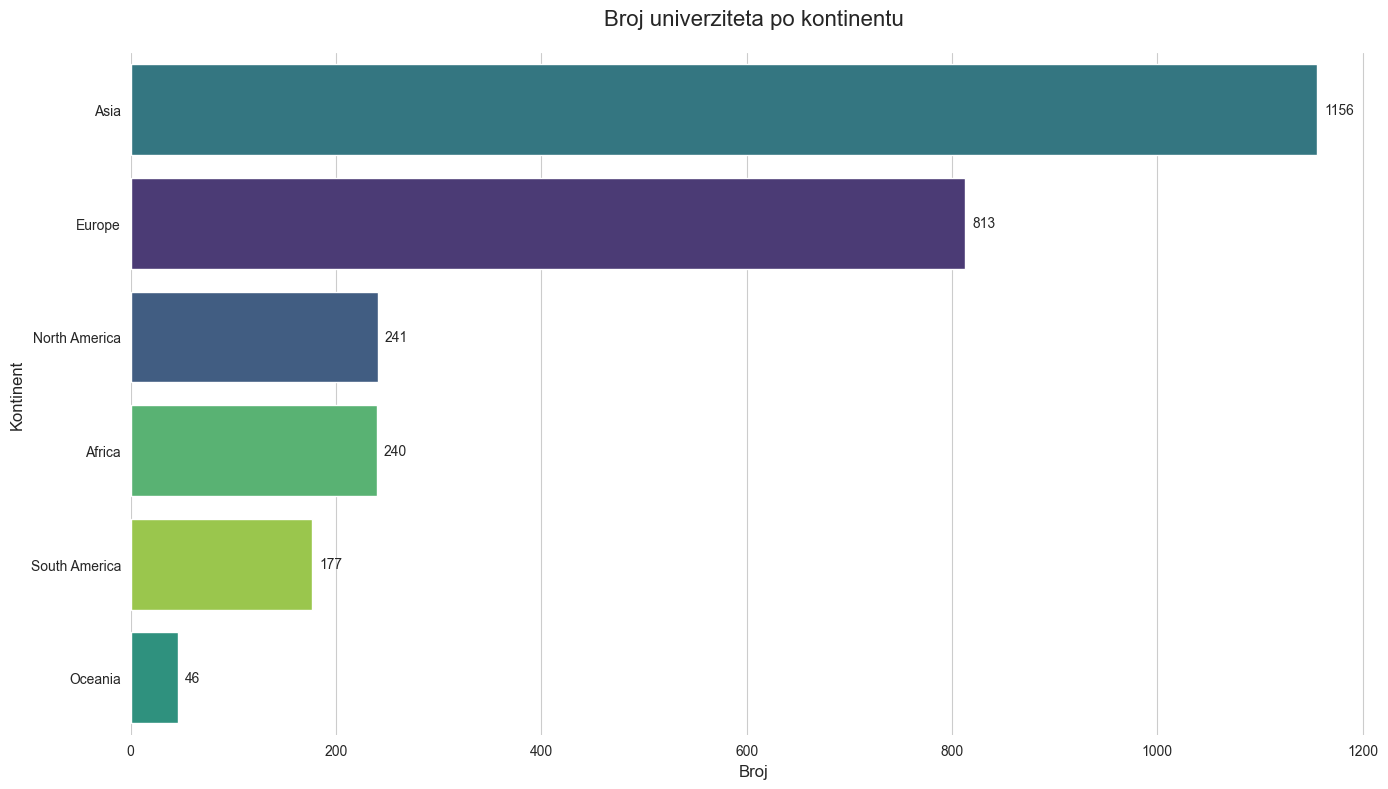

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry_convert as pc


def get_continent(country_name):
    country_mapping = {
        'USA': 'United States',
        'US': 'United States',
        'UK': 'United Kingdom',
        'UAE': 'United Arab Emirates',
        'Hong Kong': 'China',
        'Macau': 'China',
        'Republic of Ireland': 'Ireland',
        'Russian Federation': 'Russia',
        'Taiwan': 'China',
        'Palestine, State of': 'Palestine',
        'Kosovo': 'Serbia'
    }
    
    standardized_name = country_mapping.get(country_name, country_name)
    
    try:
        country_code = pc.country_name_to_country_alpha2(standardized_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        return pc.convert_continent_code_to_continent_name(continent_code)
    except:
        try:
            for suffix in [' of', ' the', ' and']:
                if suffix in standardized_name:
                    standardized_name = standardized_name.split(suffix)[0]
                    break
            country_code = pc.country_name_to_country_alpha2(standardized_name)
            continent_code = pc.country_alpha2_to_continent_code(country_code)
            return pc.convert_continent_code_to_continent_name(continent_code)
        except:
            print(f"Could not map country: {country_name}")
            return 'Unknown'

continent_data = df['location'].apply(get_continent)

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
ax = sns.countplot(y=continent_data, 
                  order=continent_data.value_counts().index,
                  hue=continent_data,  
                  palette="viridis",
                  legend=False)

for p in ax.patches:
    ax.annotate(f"{int(p.get_width()):}", 
               (p.get_width(), p.get_y() + p.get_height()/2),
               ha='left', va='center', 
               xytext=(5, 0), 
               textcoords='offset points',
               fontsize=10)

plt.title("Broj univerziteta po kontinentu", fontsize=16, pad=20)
plt.xlabel("Broj", fontsize=12)
plt.ylabel("Kontinent", fontsize=12)
sns.despine(left=True, bottom=True)
plt.tight_layout()

unmapped = df[continent_data == 'Unknown']['location'].unique()
if len(unmapped) > 0:
    print("\nUnmapped countries found:")
    for country in unmapped:
        print(f"- {country}")

plt.show()

Prije nego što prođemo kroz ovaj histogram, vrijedi spomenuti da je inicijalno došlo do sitnih problema sa pokretanjem ovog koda jer bibliotečka funkcija korištena za mapiranje država u odgovarajuće kontinente nije mogla mapirati Kosovo iz razloga što podržava samo one države i teritorije koje imaju službeni ISO 3166 kod kojeg Kosovo i dalje nema (mada neslužbeni kod XK koriste mnoge druge međunarodne organizacije). Za naše potrebe to ne pravi problem pri brojanju jer u ovom dijelu ne poredimo pojedine države, pa je bilo dovoljno instance kod kojih je polje `location` imalo vrijednost Kosovo "dodijeliti" nekoj drugoj Evropskoj državi (logičan izbor bila je Srbija). 

Napomenimo još da su u ovom histogramu uključeni i univerziteti koji nisu službeno na listi, ali se nalaze u bazi podataka.
Vidljivo je da Azija ima daleko najviše visokorangiranih univerziteta, popraćeni Evropom koja također ima respektabilan broj. Nakon toga slijede Sjeverna Amerika i Afrika sa minimalnom razlikom u broju, što je dobar pokazatelj kolika je razlika u napretku obrazovnog sistema na ovim kontinentima poredeći broj država (ništa neočekivano ako se uzmu u obzir historija i sadašnjost). Južna Amerika se pojavljuje sa 177 univerziteta. Na samom kraju imamo Okeaniju sa 46 univerziteta, ali znajući da je taj dio svijeta vrlo malo naseljen, nije se mogla ni očekivati drugačija pozicioniranost ovog "kontinenta" na listi.

In [89]:
# nisam 100% siguran oko ovog drugog paragrafa al ga neću za sad dirat, to ćemo poslije - Adnan

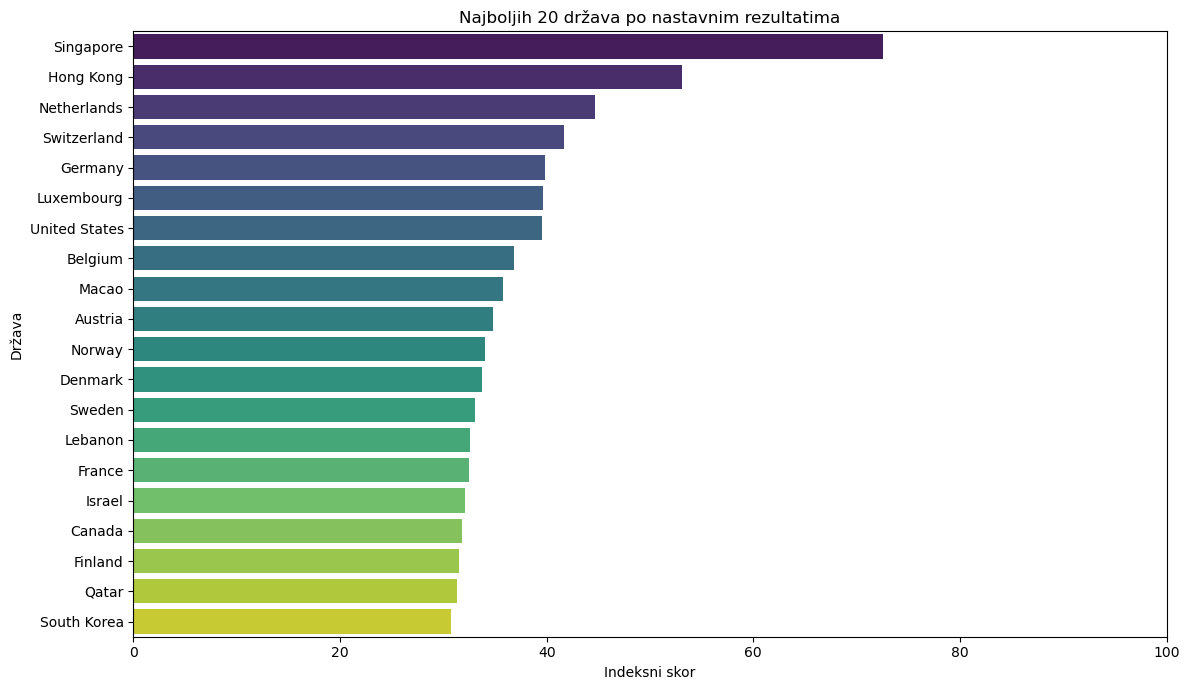

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Izračunaj medijan teaching score po državama (samo rangirani)
df_ranked = df[df['scores_overall_rank'] < 1_000_000].copy()
top_20_countries = (
    df_ranked.groupby('location')['scores_teaching']
    .median()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_20_countries,
    y='location',
    x='scores_teaching',
    palette='viridis',
    orient='h',
    hue='location',    # dodano da se ukloni upozorenje
    legend=False       # i da se ne prikazuje legenda
)
plt.title('Najboljih 20 država po nastavnim rezultatima')
plt.xlabel('Indeksni skor')
plt.ylabel('Država')
plt.xlim(0, 100)
plt.tight_layout()
plt.show()


Iznad se nalazi prikaz država sa najkvalitetnijim nastavnim procesom na univerzitetima i jasno je da je Singapur daleko ispred ostatka svijeta. Hong Kong pokušava da parira ali i pored toga što su na drugom mjestu, vidljiv je veliki jaz između njih. 
Zanimljivo je da vidimo dvije teritorije oko koje imaju bolji skor nastavnog procesa od Kine, koje su prema samom Kineskom ustavu njen dio: Hong Kong, koji je ruku na srce diskutabilan, i Makau.

In [112]:
kina = df_ranked[df_ranked['location'] == 'China']['scores_teaching']
koreja = df_ranked[df_ranked['location'] == 'South Korea']['scores_teaching']
makau = df_ranked[df_ranked['location'] == 'Macao']['scores_teaching']
hongkong = df_ranked[df_ranked['location'] == 'Hong Kong']['scores_teaching']
median_score1 = kina.median()
median_score2 = koreja.median()
median_score3 = makau.median()
median_score4 = hongkong.median()
print(f"Kina - Skor nastavnog procesa: {median_score1:.2f}")
print(f"Koreja - Skor nastavnog procesa: {median_score2:.2f}")
print(f"Makau - Skor nastavnog procesa: {median_score3:.2f}")
print(f"Hong Kong - Skor nastavnog procesa: {median_score4:.2f}")


Kina - Skor nastavnog procesa: 27.60
Koreja - Skor nastavnog procesa: 30.70
Makau - Skor nastavnog procesa: 35.75
Hong Kong - Skor nastavnog procesa: 53.10


Kina je za 3 poena iza top 20, tako da mora još poraditi na svom globalnom planu, ali ako pogledamo njene najbolje univerzitete vidjet ćemo nešto zanimljivo.

In [118]:
print(f"Kina:")
kina_top10 = df_ranked[df_ranked['location'] == 'China'].copy()
kina_top10['scores_overall_rank'] = kina_top10['scores_overall_rank'] / 10
kina_top10 = kina_top10.sort_values('scores_overall_rank').head(10)

for _, row in kina_top10.iterrows():
    rank = int(row['scores_overall_rank'])
    print(f"{rank}. {row['name']}")

print(f"\nSingapur:")
sing_top10 = df_ranked[df_ranked['location'] == 'Singapore'].copy()
sing_top10['scores_overall_rank'] = sing_top10['scores_overall_rank'] / 10
sing_top10 = sing_top10.sort_values('scores_overall_rank').head(10)

for _, row in sing_top10.iterrows():
    rank = int(row['scores_overall_rank'])  
    print(f"{rank}. {row['name']}")
print(f"\nMakau:")
macau_top10 = df_ranked[df_ranked['location'] == 'Macao'].copy()
macau_top10['scores_overall_rank'] = macau_top10['scores_overall_rank'] / 10
macau_top10 = macau_top10.sort_values('scores_overall_rank').head(10)
for _, row in macau_top10.iterrows():
    rank = int(row['scores_overall_rank'])
    print(f"{rank}. {row['name']}")

print(f"\nHong Kong:")
hk_top10 = df_ranked[df_ranked['location'] == 'Hong Kong'].copy()
hk_top10['scores_overall_rank'] = hk_top10['scores_overall_rank'] / 10
hk_top10 = hk_top10.sort_values('scores_overall_rank').head(10)
for _, row in hk_top10.iterrows():
    rank = int(row['scores_overall_rank'])
    print(f"{rank}. {row['name']}")


Kina:
12. Tsinghua University
14. Peking University
43. Shanghai Jiao Tong University
44. Fudan University
56. Zhejiang University
57. University of Science and Technology of China
73. Nanjing University
151. Sichuan University
158. Huazhong University of Science and Technology
165. Wuhan University

Singapur:
19. National University of Singapore
32. Nanyang Technological University, Singapore

Makau:
194. University of Macau
275. Macau University of Science and Technology

Hong Kong:
35. University of Hong Kong
53. Chinese University of Hong Kong
65. The Hong Kong University of Science and Technology
82. City University of Hong Kong
88. Hong Kong Polytechnic University
319. Hong Kong Baptist University


Svi kineski najbolji univerziteti (uzeli smo samo prvih 10) su unutar top 200 na svjetskoj listi, dok Singapur recimo ima samo 2 univerziteta uopće na listi, gdje su oba u top 35. Hong Kong je također respektabilan sa 5 univerziteta unutar top 100, ali definitivno najzanimljiviji detalj jest Makau, koji ima 2 rangirana univerziteta, kao i Singapur, gdje jedan jedva ulazi unutar top 200, ali i dalje ima bolju medijanu nego Kina. Dovoljan pokazatelj da podaci zaista znaju da zavaraju ako se uzimaju izvan konteksta. Možemo pretpostaviti jednu od 2 stvari bez dublje analize: ili Makau zaista ima vrlo kvalitetan nastavni proces ili Kina (i mnoge zemlje sa većim brojem stanovnika) postaju "žrtve" velike brojnosti koja ima za efekat pomjeranje na listi prema dole.

Pogledajmo nabrzaka stanje na našem poluotoku i broj univerziteta na listi po svakoj državi.

In [90]:
balkanske_drzave = {
    'Albanija': 'ALB',
    'Bosna i Hercegovina': 'BIH',
    'Bugarska': 'BGR',
    'Hrvatska': 'HRV',
    'Grčka': 'GRC',
    'Crna Gora': 'MNE',
    'Sjeverna Makedonija': 'MKD',
    'Rumunija': 'ROU',
    'Srbija': 'SRB',  
    'Slovenija': 'SVN',
    'Turska': 'TUR'  
}

balkanski_podaci = df[df['location'].isin([
    'Albania', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia',
    'Greece', 'Montenegro', 'North Macedonia',
    'Romania', 'Serbia', 'Slovenia', 'Kosovo', 'Turkey'
])].copy()

balkanski_podaci['location'] = balkanski_podaci['location'].replace({
    'Kosovo': 'Serbia',
})

broj_univerziteta = balkanski_podaci['location'].value_counts().reset_index()
broj_univerziteta.columns = ['Država', 'Broj univerziteta']

prevod = {
    'Serbia': 'Srbija',
    'Montenegro': 'Crna Gora',
    'North Macedonia': 'Sjeverna Makedonija',
    'Albania': 'Albanija',
    'Bosnia and Herzegovina': 'Bosna i Hercegovina',
    'Bulgaria': 'Bugarska',
    'Croatia': 'Hrvatska',
    'Greece': 'Grčka',
    'Romania': 'Rumunija',
    'Slovenia': 'Slovenija',
    'Turkey': 'Turska'  
}

broj_univerziteta['Država'] = broj_univerziteta['Država'].map(prevod)

broj_univerziteta['ISO_kod'] = broj_univerziteta['Država'].map(balkanske_drzave)

import plotly.express as px

figura = px.choropleth(
    broj_univerziteta,
    locations='ISO_kod',
    color='Broj univerziteta',
    scope='europe',
    color_continuous_scale='OrRd',
    title='<b>Broj univerziteta na listi po balkanskim državama</b>',
    labels={'Broj univerziteta': 'Broj univerziteta'},
    hover_name='Država',
    hover_data={'ISO_kod': False}
)

figura.update_geos(
    visible=False,
    resolution=50,
    scope='world',
    center=dict(lon=22, lat=42),
    lataxis_range=[37, 47],     
    lonaxis_range=[14, 32]      
)



figura.update_layout(
    margin={"r":0,"t":40,"l":0,"b":0},
    width=900,
    height=600,
    coloraxis_colorbar=dict(
        title="Broj univerziteta",
        thickness=15,
        len=0.75
    )
)

import plotly.io as pio
pio.renderers.default = 'colab'  

figura.show()


Vidimo jedan zanimljiv interaktivni prikaz broja univerziteta na listi iz balkanskih država gdje je vidljivo da Turska dominira sa čak 97 univerziteta, dok recimo Albanija nema niti jednog. Iako mapa prikazuje Kosovo kao nezavisnu teritoriju, zbog političke korektnosti i stava države Bosne i Hercegovine o njegovom statusu, odabrali smo da te univerzitete ne navodimo kao odvojenu cjelinu (naravno, nije ovo jedini problem bio pri analizi i kodu, drugi je već ranije spomenut)

Sada pogledajmo kakve opcije imaju budući studenti na globalnom planu, koji fakulteti su najzastupljeniji među univerzitetima na listi.

In [91]:
import pandas as pd
import plotly.express as px

df_ranked = df[df['scores_overall_rank'] < 1_000_000].copy()

subjects_series = df_ranked['subjects_offered'].dropna()

all_subjects = []
for subj_list in subjects_series:
    subjects = [s.strip() for s in subj_list.split(',')]
    all_subjects.extend(subjects)

from collections import Counter
subject_counts = Counter(all_subjects)

subject_freq = pd.DataFrame(subject_counts.items(), columns=['Subject', 'Count'])
subject_freq = subject_freq.sort_values(by='Count', ascending=False)

fig = px.bar(
    subject_freq.head(20), 
    x='Subject',
    y='Count',
    title='Najčešće ponuđeni predmeti na univerzitetima',
    labels={'Count': 'Broj univerziteta', 'Subject': 'Predmet'},
    text='Count'
)
fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_tickangle=45,
    height=600
)
fig.show()

Histogramom se da zaključiti da su _Computer Science_ i _Business & Management_ najzastupljeniji fakulteti/odsjeci na univerzitetima sa liste. S obzirom da ovu analizu vrše studenti odsjeka RI (kursa), možemo samo anglosaksonskom terminologijom kazati "We're cooked". 

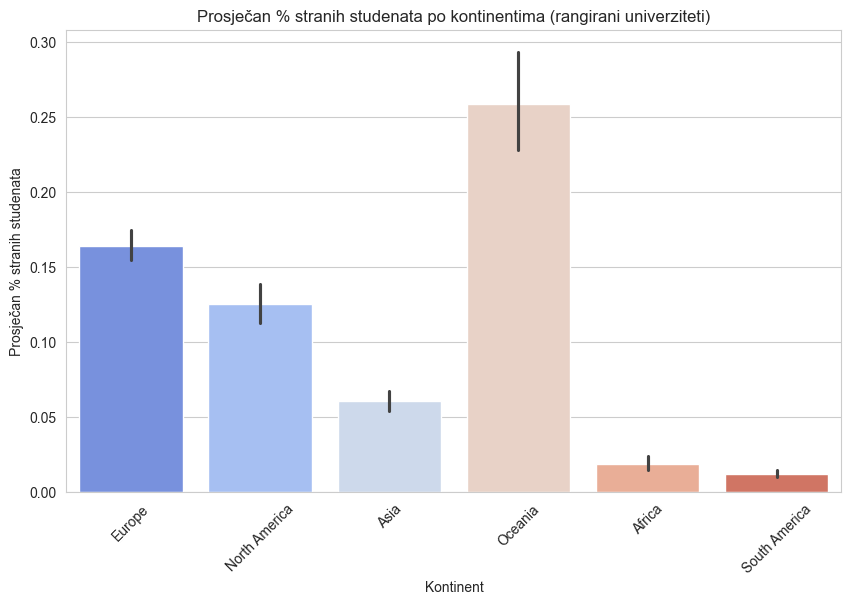

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

df['Continent'] = df['location'].apply(get_continent)


df_valid = df[df['scores_overall_rank'] < 1_000_000].copy()

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_valid,
    x='Continent',
    y='stats_pc_intl_students',
    estimator=lambda x: x.mean(),
    palette='coolwarm',
    hue='Continent',    
    legend=False        
)
plt.title('Prosječan % stranih studenata po kontinentima (rangirani univerziteti)')
plt.ylabel('Prosječan % stranih studenata')
plt.xlabel('Kontinent')
plt.xticks(rotation=45)
plt.show()

Vidimo konačno jednu statistiku u kojoj predvodi Okeanija, % stranih studenata, sa nešto više od 25%. Možemo pretpostaviti da je glavni razlog sljedeće situacije manji broj stanovnika na ovom kontinentu u poređenju sa ostalima.
Na listi slijede Evropa (~16%) i Sjeverna Amerika(~13%). Azija ima tek oko 6% stranih studenata, ali tu možemo pretpostaviti da je razlog suprotan onome za Okeaniju. 
Afrika i Južna Amerika su na samom dnu liste sa oko 2 i 1 posto stranih studenata respektivno.

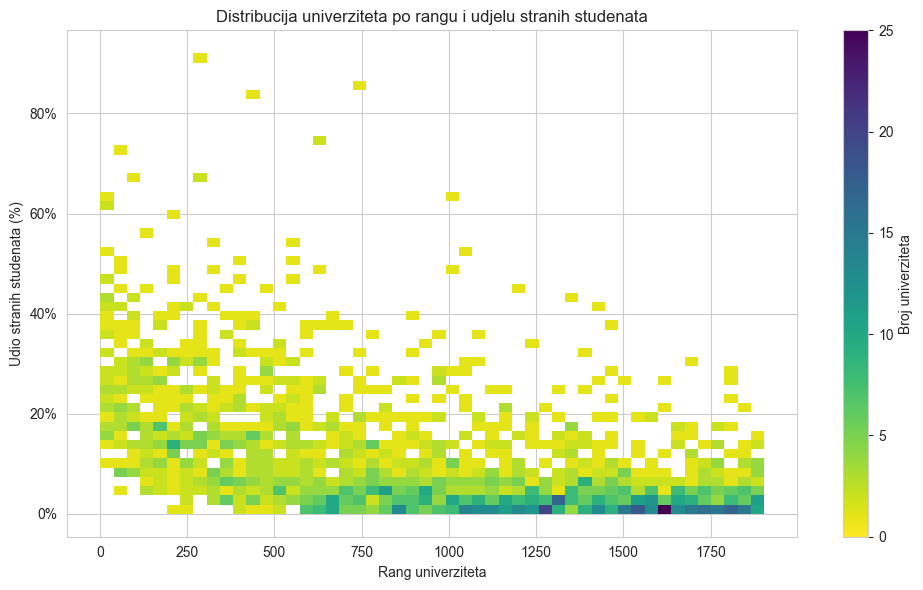

In [ ]:
import matplotlib.ticker as mtick

df_valid = df[df['scores_overall_rank'].astype(float) < 1_000_000].copy()

df_valid['stats_pc_intl_students'] = pd.to_numeric(df_valid['stats_pc_intl_students'], errors='coerce')
df_valid['scores_overall_rank'] = pd.to_numeric(df_valid['scores_overall_rank'], errors='coerce')

df_valid = df_valid.dropna(subset=['stats_pc_intl_students', 'scores_overall_rank'])

df_valid['scaled_rank'] = df_valid['scores_overall_rank'] / 10

if df_valid['stats_pc_intl_students'].max() <= 1.0:
    df_valid['stats_pc_intl_students'] *= 100

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_valid,
    x='scaled_rank',
    y='stats_pc_intl_students',
    bins=50,
    cmap='viridis_r',       
    cbar=True,
    cbar_kws={'label': 'Broj univerziteta'},
    vmin=0,                
    vmax=None              
)

plt.title('Distribucija univerziteta po rangu i udjelu stranih studenata')
plt.xlabel('Rang univerziteta')
plt.ylabel('Udio stranih studenata (%)')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
plt.tight_layout()
plt.show()

Ovaj heatmap poredi postotak stranih studenata na nekom univerzitetu i njegov rang na listi. Primjetno je da oni najbolji unverziteti imaju velik broj stranih studenata. To je dosta razumljivo jer najbolji učenici žele na najbolje fakultete, a to nerijetko znači odlazak u drugu državu radi obrazovanja. Isto tako i univerziteti žele najbolje studente, tako da se često prave i dodatna mjesta isključivo za strane studente. 

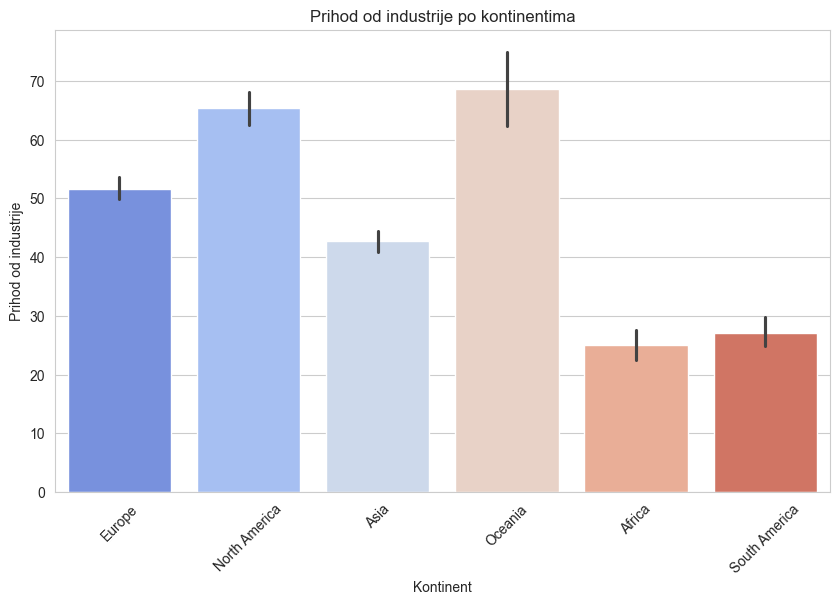

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_valid,
    x='Continent',
    y='scores_industry_income',
    estimator=lambda x: x.mean(),
    palette='coolwarm',
    hue='Continent',
    legend=False
)
plt.title('Prihod od industrije po kontinentima')
plt.ylabel('Prihod od industrije')
plt.xlabel('Kontinent')
plt.xticks(rotation=45)
plt.show()

Pogledajmo još jedan interesantan graf koji prikazuje koliko univerziteti dobivaju novca od privrednih subjekata, što kroz finansiranje istraživanja, što kroz ulaganje u buduće radnike, kao i nosioce same privrede u državi. 
Okeanija je ponovo na vrhu liste, te sada bilježe najbolje rezultate po ovom pitanju. Sjevernoamerički univerziteti ih prate u stopu i jasno je da privreda ulaže mnogo u svoju budućnost. Slijede Evropa i Azija, i na samom dnu liste vidimo Afriku i Južnu Ameriku. S obzirom na okolnosti možda je i očekivano da vidimo ove kontinente na dnu, ali se iskreno nadamo da će se u skorijoj budućnosti to stanje popraviti.

### <p>2. <a href="https://en.wikipedia.org/wiki/Probability_distribution_fitting" style="color:inherit">Prilagođavanje distribucija vjerovatnoće podataka</a> <br> _(eng. Probability distribution fitting)_</p>

Član tima: **Aid Mustafić**

---

### 3. Provjera prilagođenih distribucija - _[Chi-kvadratni goodness-of-fit test](https://www.geo.fu-berlin.de/en/v/soga-py/Basics-of-statistics/Hypothesis-Tests/Chi-Square-Tests/Chi-Square-Goodness-of-Fit-Test/index.html)_
Član tima: **Adnan Muradbegović**

---

### 4. Provjera statističkih normalnosti - _[Kolmogorov–Smirnov, Shapiro–Wilk i QQ-plot](https://en.wikipedia.org/wiki/Normality_test)_


Član tima: **Adnan Muradbegović**

---

### 5. Estimacija intervala pouzdanosti _(eng. confidence intervals)_


Član tima: **Zlatan Ljutika**

---

### 6. Estimacija pouzdanosti proporcije _(eng. proportion confidence intervals)_


Član tima: **Tarik Redžić**

---

## **Statistička inferencija seta podataka**

Da bi na osnovu do sada posmatranog seta podataka uspjeli istaknuti konkretne i korisne zaključke, u ovom poglavlju ćemo primjeniti metodu statističkog inferenciranja, testiranje statističkih hipoteza (eng. statistical hypothesis testing).

...

**Hipoteza 1.:** Rangirani univerziteti u Sjedinjenim Američkim Državama u prosjeku primaju više prihoda iz industrije od rangiranih univerziteta u Ujedinjenom Kraljevstvu (Predstavlja: Adnan Muradbegović)<br>
**Hipoteza 2.:** Univerziteti sa nižom proporcijom studenata po nastavnom osoblju su ostvarili više bodova za kvalitet nastave. (Predstavlja: Zlatan Ljutika)<br>
**Hipoteza 3.:** Državni univerziteti na Balkanu imaju prosječno bolje rezultate za nastavu od privatnih. (Predstavlja: Aid Mustafić)<br>
**Hipoteza 4.:** Međunarodna povezanost Univerziteta u Sarajevu je značajno ispod evropskog prosjeka (Predstavlja: Tarik Redžić)<br>

### 2.1. **Hipoteza:** Rangirani univerziteti u Sjedinjenim Američkim Državama u prosjeku primaju više prihoda iz industrije od rangiranih univerziteta u Ujedinjenom Kraljevstvu

Član tima: **Adnan Muradbegović**

---

Sjedinjene Američke Države se po BDP-u i dalje smatraju najvećom svjetskom ekonomijom, iako im se zadnjih par desetljeća Kina opasno približava. Svoga bivšeg gospodara, Ujedinjeno Kraljevstvo, pretekle su prije preko stotinu godina. Nekadašnje carstvo se po mnogo ćemu nalazi u sjeni Amerike, no visoko obrazovanje (u kojem ima tradiciju stariju od prvog kontakta evropljana sa američkim tlom) nije jedna od tih stvari. Neka od "najzvučnijih" imena univerziteta su upravo imena univerziteta iz Velike Britanije kao što su Oxford, Cambridge i Warwick (ovom prilikom pozdravljam četiri drugarice iz srednje škole koje su primljene na ova dva univerziteta). Poznati britanski univerziteti se kao što smo ranije vidjeli nalaze pri vrhu rang liste, skupa sa Ivy League i drugim prestižnim američkim univerzitetima, te im po mnogim pokazateljima konkuririraju. Također, iako su Sjedinjene Države mnogo veće, na listi se nalazi 169 američkih univerziteta, a 104 britanska što nije velika razlika uzimajući u obzir da u SAD-u živi preko 5 puta više ljudi. 

Ipak, vrijedilo bi pretpostaviti da univerziteti u SAD-u uživaju u mnogo više investicija iz industrije, s obzirom na masivnost američke ekonomije kao i na blisku saradnju sa vojnom industrijom koja je rezultovala u nekim od najvećih tehnoloških otkrića i izuma prošlog i trenutnog stoljeća, od kojih su mnogi kasnije plasirani i običnim potrošačima.

Metrika koja u izabranom _data set_-u mjeri prihode koje institucija dobiva iz industrije, skalirana po kupovnoj moći i količini uposlenika, je `scores_industry_income`. (Detaljnije objašnjeno na službenoj stranici: https://www.timeshighereducation.com/world-university-rankings/world-university-rankings-2024-methodology)

Naravno, da bismo mogli vjerovati u tačnost naše tvrdnje, potreban nam je prikladan matematički dokaz. Koristiti ćemo metode testiranja hipoteza koje smo tokom semestra obradili na predmetu. 

Do čvrstog zaključka se dolazi isključivo **odbacivanjem** hipoteze. Naravno, mi navedenu tvrdnju ne želimo odbaciti nego dokazati. Zbog toga ćemo prvo postaviti **null hipotezu** (oznaka: $H_0$) koja predstavlja logički komplement naše tvrdnje da univerziteti su Sjedinjenim Američkim Državama u prosjeku primaju više prihoda iz industrije od univerziteta u Ujedinjenom Kraljevstvu. Sama tvrdnja onda predstavlja **alternativnu hipotezu** (oznaka: $H_1$) koju ćemo prihvatiti ako i samo ako uspijemo odbaciti hipotezu $H_0$. 

Kako se radi o poređenju srednjih vrijednosti uzoraka iz dvije različite populacije, procedura testiranja hipoteze će biti vrlo jednostavna i "školska". Hipoteze $H_0$ i $H_1$ ćemo zapisati kao:
$$
H_0: \mu_1 - \mu_2 = 0,\\
H_0: \mu_1 - \mu_2 > 0.
$$

Ovdje je $\mu_1$ naravno srednja vrijednost metrike `scores_industry_income` za rangirane američke univerzitete, kako nam je cilj dokazati da američki univerziteti u prosjeku imaju više prihoda iz industrije, odnosno da je $\mu_1 - \mu_2$ pozitivna vrijednost. Kako nam nisu poznate varijanse uzoraka iz dvije posmatrane populacije, koristiti ćemo aproksimaciju $t$ statistike za slučaj nepoznatih i nejednakih varijansi populacije datu formulom:
$$
t' = \frac{(\bar{x}_1 - \bar{x}_2) - d_0}{\sqrt{s_1^2/n_1 +s_2^2/n_2}}
$$
Ovdje su $\bar{x}_1$ i $\bar{x}_2$ proračunate srednje vrijednosti uzorka, $s_1^2$ i $s_2^2$ proračunate varijanse uzoraka, $n_1$ i $n_2$ veličine dva uzorka, a $d_0$ razlika srednjih vrijednosti koja je pretpostavljena u $H_0$, što je u našem slučaju jednostavno $0$.

Stepeni slobode $v$ se u ovom slučaju aproksimiraju sljedećom formulom (zaokružuje se na manji prirodan broj):
$$
v=\frac{(s_1^2/n_1+s_2^2/n_2)^2}{\frac{(s_1^2/n_1)^2}{n_1-1} + \frac{(s_2^2/n_2)^2}{n_2-1}}
$$

Kako je $H_1$ jednostrana, odgovarajuća kritična oblast nam je $t'>t_\alpha$. Za $\alpha$ ćemo odabrati $0.05$.

Sljedeći isječak koda izvršiti će proračune potrebne da bismo mogli potvrditi ili odbaciti našu tvrdnju.

In [91]:
americki_univerziteti = df_ranked[df_ranked['location'] == 'United States'].copy()
britanski_univerziteti = df_ranked[df_ranked['location'] == 'United Kingdom'].copy()

n_americkih = len(americki_univerziteti)
n_britanskih = len(britanski_univerziteti)

print(f"Broj američkih univerziteta: {n_americkih}")
print(f"Broj britanskih univerziteta: {n_britanskih}")

americki_prosjek = americki_univerziteti['scores_industry_income'].mean()
britanski_prosjek = britanski_univerziteti['scores_industry_income'].mean()
print(f"Prosječan prihod iz industrije američkih univerziteta: {americki_prosjek:.2f}")
print(f"Prosječan prihod iz industrije britanskih univerziteta: {britanski_prosjek:.2f}")

americka_varijansa = americki_univerziteti['scores_industry_income'].var()
britanska_varijansa = britanski_univerziteti['scores_industry_income'].var()
print(f"Varijansa prihoda iz industrije američkih univerziteta: {americka_varijansa:.2f}")
print(f"Varijansa prihoda iz industrije britanskih univerziteta: {britanska_varijansa:.2f}")

t = (americki_prosjek - britanski_prosjek) / np.sqrt((americka_varijansa / n_americkih) + (britanska_varijansa / n_britanskih))
print(f"T-statistika: {t:.2f}")

v = int((americka_varijansa/n_americkih + britanska_varijansa/n_britanskih)**2 / \
    ((americka_varijansa/n_americkih)**2 / (n_americkih - 1) + (britanska_varijansa/n_britanskih)**2 / (n_britanskih - 1)))
print(f"Stepeni slobode: {v}")


Broj američkih univerziteta: 169
Broj britanskih univerziteta: 104
Prosječan prihod iz industrije američkih univerziteta: 69.63
Prosječan prihod iz industrije britanskih univerziteta: 52.13
Varijansa prihoda iz industrije američkih univerziteta: 319.83
Varijansa prihoda iz industrije britanskih univerziteta: 385.43
T-statistika: 7.39
Stepeni slobode: 202


Kritičnu vrijednost $t$ za $202$ stepena slobode možemo vrlo vrlo precizno aproksimirati kritičnom vrijednosti $t$ za $\infty$, tako da će kritični regijon biti $t > 1.645$ u šta ulazi proračunata vrijednost T-statistike od $7.39$. Odatle zaključujemo da je $t$-statistika signifikantna na nivou $0.05$ i odbacujemo hipotezu $H_0$. Samim time prihvatamo alternativnu hipotezu $H_1$ i zaključujemo da **rangirani američki univerziteti zaista u prosjeku, barem prema dostupnoj metrici, dolaze do značajnijih prihoda odnosno investicija iz industrije**.

Sljedeći graf vizualizira usporedbu vrijednosti `score_industry_income` za univerzitete u Sjedinjenim Američkim Državama i Ujedinjenom Kraljevstvu:

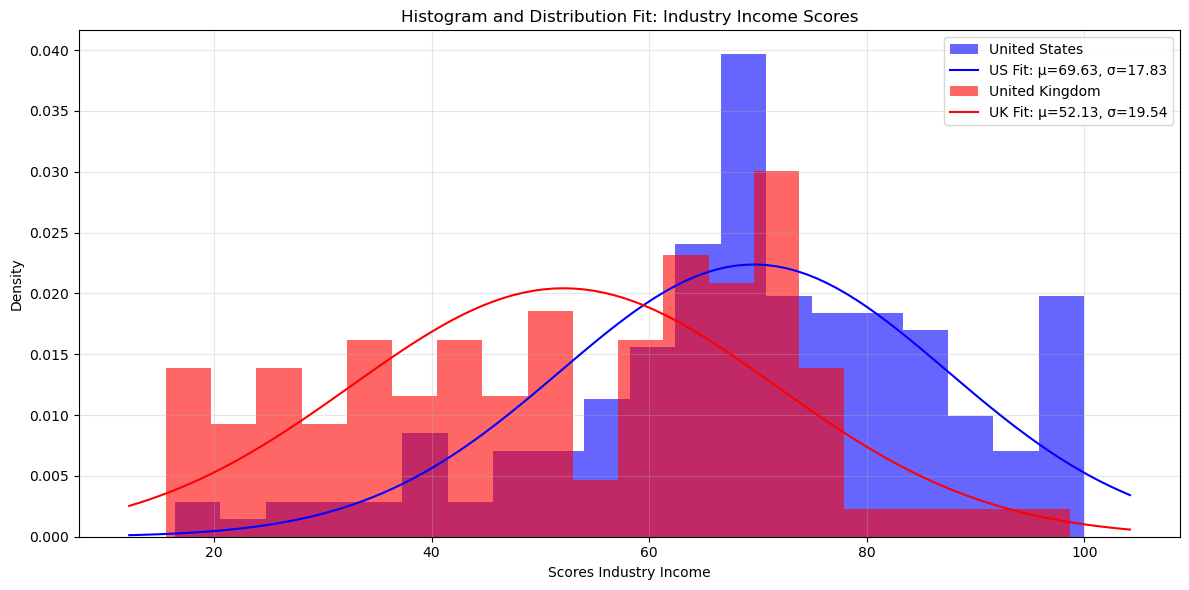

In [ ]:
# Filter data for United States and United Kingdom
us_data = americki_univerziteti['scores_industry_income']
uk_data = britanski_univerziteti['scores_industry_income']

# Fit normal distributions
us_mean, us_std = norm.fit(us_data)
uk_mean, uk_std = norm.fit(uk_data)

# Generate histogram and fitted distribution for United States
plt.figure(figsize=(12, 6))
plt.hist(us_data, bins=20, density=True, alpha=0.6, color='blue', label='Sjedinjene Američke Države')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
us_pdf = norm.pdf(x, us_mean, us_std)
plt.plot(x, us_pdf, 'blue', label=f'US Fit: μ={us_mean:.2f}, σ={us_std:.2f}')
plt.axvline(us_mean, color='blue', linestyle='--', label=f'US Mean: {us_mean:.2f}')

# Generate histogram and fitted distribution for United Kingdom
plt.hist(uk_data, bins=20, density=True, alpha=0.6, color='red', label='Ujedinjeno Kraljevstvo')
uk_pdf = norm.pdf(x, uk_mean, uk_std)
plt.plot(x, uk_pdf, 'red', label=f'UK Fit: μ={uk_mean:.2f}, σ={uk_std:.2f}')
plt.axvline(uk_mean, color='red', linestyle='--', label=f'UK Mean: {uk_mean:.2f}')

# Add labels and legend
plt.title('Usporedba prihoda iz industrije za univerzitete u SAD-u i Ujedinjenom Kraljevstvu')
plt.xlabel('Metrika za prihode iz industrije')
plt.ylabel('Gustina')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 2.2. **Hipoteza:** Univerziteti sa nižom proporcijom studenata po nastavnom osoblju su ostvarili više bodova za kvalitet nastave.
Član tima: **Ljut**

---

Sama tvrdnja je vrlo očigledna. Ako je profesor ili asistent odgovoran za manji broj studenata, svakom se individualno može više posvetiti što tokom nastave na predmetima u vidu konsultacija i detaljnih uvida u radove, što kroz kvalitetnije mentorstvo prilikom izrade diplomskog, magistarskog ili doktorskog rada. Iskustvo nam naravno govori da se ova proporcija studenata po nastavnom osoblju unutar konkretnog univerziteta razlikuje i među fakultetima i odsjecima. Mnoge studijske programe na Filozofskom fakultetu upiše manje od 10 redovnih studenata (konkretan primjer je Francuski Jezik i književnost, kao i svaki drugi studijski program Odsjeka za romanistiku), dok su Računarstvo i informatiku na Elektrotehničkom fakultetu prošle godine upisala čak 153 studenta. Međutim, kako se radi o poređenju između univerziteta, to nećemo uzimati u obzir nego ćemo posmatrati kako u globalu proporcija studenata i nastavnog osoblja utiče na kvalitet nastave. Na mnogim univerzitetima studenti imaju više slobode da biraju predmete koji pripadaju drugim odsjecima, tako da razmatranje broja studenata po nastavnom osoblju za kompletne univerzitete nije bezrazložno (na kraju, taj podatak je u tabeli prisutan sa razlogom).

Da bismo testirali hipotezu, treba nam neka **testna statistika**. Za ovu hipotezu će je biti nešto komplikovanije odrediti iz razloga što se radi o poređenju dvije različite varijable, dok u ostalim hipotezama uglavnom poredimo svojstva jedne varijable za dva različita uzorka. Možda bi najbolje bilo nekako izračunati koeficijent korelacije za ove dvije numeričke varijable. Za tu svrhu ćemo koristiti **koeficijent korelacije uzorka** $r$, odnosno Pearsonov koeficijent korelacije, koji estimira koeficijent korelacije populacije $\rho$. Formula za računanje koeficijenta korelacije uzorka koju ćemo koristiti je sljedeća:
$$
r=\frac{S_{xy}}{\sqrt{S_{xx} S_{yy}}}
$$
Ovdje su $S_{xx}$ i $S_{yy}$ redom standardne devijacije _uzorka_ nasumičnih varijabli `stats_student_staff_ratio` i `scores_teaching`. $S_{xy}$ je onda naravno njihova kovarijansa. Zatim ćemo izračunati odgovarajuću $t$-statistiku (koja će biti naša testna statistika) formulom:
$$
t=\frac{r\sqrt{n-2}}{\sqrt{1-r^2}}
$$

Ono što mi ovdje sa matematičke strane želimo dokazati jeste postojanje negativne linearne korelacije između posmatranih numeričkih varijabli `scores_teaching` i `stats_student_staff_ratio`. Tako da će konačna postavka nulte i alternativne hipoteze glasiti ovako:
$$
H_0 :\quad \rho = 0, \\
H_1 :\quad \rho < 0.
$$
Za **nivo signifikantnosti** $\alpha$ praksa je obično uzeti $0.05$ ili $0.01$. Mi ćemo odabrati $0.05$. Kako nam je hipoteza $H_1$ jednostrana, takva mora biti i kritična oblast. Za veliko $n$ i $\alpha=0.05$, kritična oblast je $t < -1.645$. Izabrali smo jednostranu kritičnu oblast sa lijeve strane zbog načina na koji je postavljena hipoteza $H_1$.



In [58]:
# ova bibliotečka funkcija za nas radi sav posao računanja Pearsonovog koeficijenta korelacije  
r = df_ranked.corr(method='pearson', numeric_only=True).loc['stats_student_staff_ratio', 'scores_teaching']
n = len(df_ranked)
t = r * np.sqrt(n-2) / np.sqrt(1-r**2)

print("r = ", r)
print("t = ", t)

r =  -0.23424275070679626
t =  -10.508133088991787


Proračunata vrijednost $t$ iznosi $-10.5081$ što pripada kritičnoj oblasti. To uzimamo kao dovoljan razlog za odbacivanje nulte hipoteze $H_0$ čime prihvatamo našu inicijalnu tvrdnju da je nastava na univerzitetima gdje su pojedini uposlenici manje opterećeni brojem studenata bolja. Sljedeći  _scatter plot_ vizualizira vezu između dvije razmatrane numeričke varijable i ne protivrječi se sa našom hipotezom:

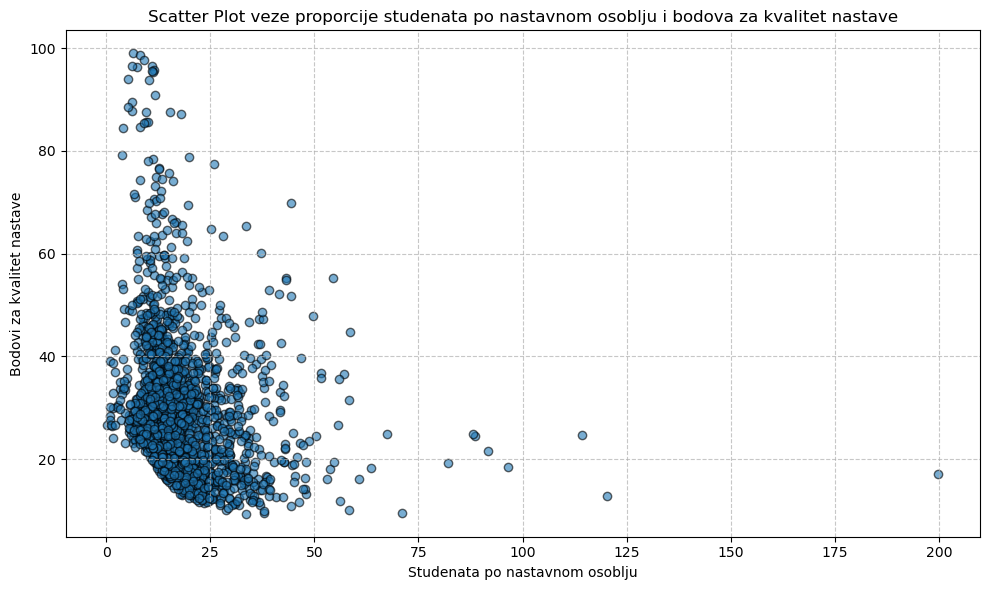

In [74]:
plt.figure(figsize=(10, 6))
plt.scatter(df_ranked['stats_student_staff_ratio'], df_ranked['scores_teaching'], alpha=0.6, edgecolor='k')
plt.title('Scatter Plot veze proporcije studenata po nastavnom osoblju i bodova za kvalitet nastave')
plt.xlabel('Studenata po nastavnom osoblju')
plt.ylabel('Bodovi za kvalitet nastave')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Na prikazanom grafu se daju primijetiti _outlieri_, koji, mada nam pokazuju da je za ekstremne slučajeve proporcije studenata po nastavnom osoblju, broj bodova koji opisuju ocjenjuju kvalitet nastave nizak, mogu smetati proračunu Pearsonovog koeficijenta korelacije koji je osjetljiv na _outliere_. Iako je jasno da je korelacija negativna, nije pretjerano izražena (koeficijent iznosi oko $-0.2342$). Zato ćemo još jednom, čisto da bi imali jaču tvrdnju za univerzitete koji su nešto bliži srednjoj vrijednosti i koji nisu "ekstremni" po pitanju ove proporcije, ponoviti proračun razmatrajući 90% uzorka gdje je uklonjeno 5% instanci sa najmanjom i 5% instanci sa najvećom proporcijom studenata po nastavnom osoblju. 

In [80]:
lower_bound = df_ranked['stats_student_staff_ratio'].quantile(0.05)
upper_bound = df_ranked['stats_student_staff_ratio'].quantile(0.95)
filtered_df_no_outliers = df_ranked[(df_ranked['stats_student_staff_ratio'] >= lower_bound) & (df_ranked['stats_student_staff_ratio'] <= upper_bound)]
#filtered_df_no_outliers = df_ranked[(df_ranked['stats_student_staff_ratio'] <= upper_bound)]

r_no_outliers = filtered_df_no_outliers.corr(method='pearson', numeric_only=True).loc['stats_student_staff_ratio', 'scores_teaching']
n_no_outliers = len(filtered_df_no_outliers)
t_no_outliers = r_no_outliers * np.sqrt(n_no_outliers - 2) / np.sqrt(1 - r_no_outliers**2)
print("r = ", r_no_outliers)
print("t = ", t_no_outliers)

r =  -0.2993187366494712
t =  -12.975999063184902


Možemo uočiti promjene u vrijednostima $r$ i $t$ koje pokazuju da je tvrdnja jača kada posmatramo nešto "uži" uzorak (uži u smislu manje varijanse). Sam grafički prikaz sada također jasnije prikazuje linearnu vezu. Ovaj put ćemo preko grafika prikazati i linearnu funkciju koja aproksimira vezu između ove dvije numeričke varijable, čisto da bi se vidjelo da je ona opadajuća. 

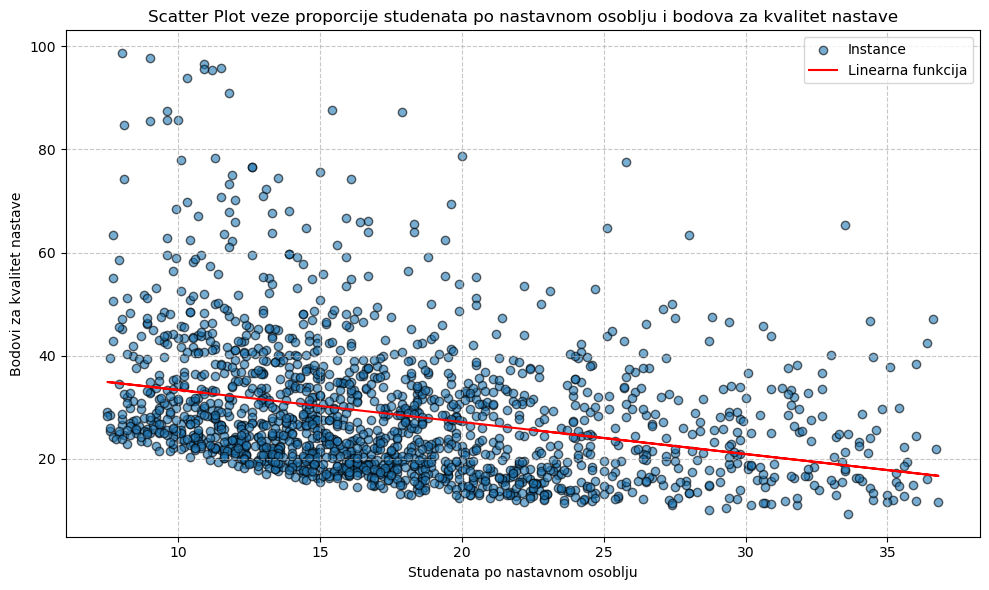

In [86]:
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(filtered_df_no_outliers['stats_student_staff_ratio'], filtered_df_no_outliers['scores_teaching'], alpha=0.6, edgecolor='k', label='Instance')

# Linear regression line
x_vals = filtered_df_no_outliers['stats_student_staff_ratio']
# Define slope and intercept through mathematical formulas
covariance = np.cov(filtered_df_no_outliers['stats_student_staff_ratio'], filtered_df_no_outliers['scores_teaching'])[0, 1]
variance = np.var(filtered_df_no_outliers['stats_student_staff_ratio'], ddof=1)
slope = covariance / variance
intercept = filtered_df_no_outliers['scores_teaching'].mean() - slope * filtered_df_no_outliers['stats_student_staff_ratio'].mean()
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='red', label='Linearna funkcija')

# Labels and title
plt.title('Scatter Plot veze proporcije studenata po nastavnom osoblju i bodova za kvalitet nastave')
plt.xlabel('Studenata po nastavnom osoblju')
plt.ylabel('Bodovi za kvalitet nastave')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

### 2.3. **Hipoteza:** Državni univerziteti na Balkanu imaju prosječno bolje rezultate za nastavu od privatnih.

Član tima: **Aid Mustafić**

---

### 2.4. **Hipoteza:** Međunarodna povezanost Univerziteta u Sarajevu je značajno ispod evropskog prosjeka 

Član tima: **Tarik Redžić**

---

## **Linearni regresivni model seta podataka**

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Ut a volutpat nulla. Donec eu ante eget nisl posuere scelerisque. Nulla sed eros purus. In placerat diam vel augue aliquet, sit amet faucibus sem sagittis. Interdum et malesuada fames ac ante ipsum primis in faucibus. Vestibulum id diam magna. Curabitur porta urna ante, et aliquet odio blandit at. Cras viverra tellus id pulvinar rhoncus. Praesent id ullamcorper dolor. Nulla lacinia arcu a massa sollicitudin ullamcorper.

predvidjeti overall_score?

# Dobri linkovi


[1]https://www.timeshighereducation.com/world-university-rankings/world-university-rankings-2024-china-creeps-closer-top-10  
[Desno pored ranga ima sekcija "Academic insights", može mnogo poslužiti]https://www.timeshighereducation.com/world-university-rankings/2024/world-ranking 
[3]https://www.timeshighereducation.com/sites/default/files/the_2024_world_university_rankings_methodology.pdf
